## IMPORT

In [1]:
import pandas as pd 
import numpy as np 
import math as math
import joblib
from joblib import dump
import os
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## DATA TEST

In [3]:
def load_Dataset(baseFile, fold_Number): 
    rnmColData = ['user_id', 'item_id', 'rating', 'timestamp']
    test_File = f"{baseFile}/u{fold_Number}.test"
    test_Data = pd.read_csv(test_File, sep="\t", header=None, names=rnmColData)
    test_Data = test_Data.drop(columns=["timestamp"])
    return test_Data

In [4]:
call_base = "../ml-100k"
testdata = load_Dataset(call_base, 1)
testdata


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3
...,...,...,...
19995,458,648,4
19996,458,1101,4
19997,459,934,3
19998,460,10,3


In [5]:
def GetUniqueUserItemShape(ratingData, fold_num=1):
    max_user = ratingData['user_id'].max()
    unique_user_count = ratingData['user_id'].nunique()
    unique_item_count = ratingData['item_id'].nunique()
    # sparasity
    sparsity = 1 - (len(ratingData) / (max_user * unique_item_count))
    result = f"fold {fold_num}, uniq user =  {unique_user_count},uniq item = {unique_item_count},max user = {max_user}, sparsity = {sparsity:.4f}"
    return result

# Loop untuk fold 1 sampai 5
for fold in range(1, 6):
    testdata = load_Dataset(call_base, fold)
    output = GetUniqueUserItemShape(testdata, fold)
    print(output)


fold 1, uniq user =  459,uniq item = 1410,max user = 462, sparsity = 0.9693
fold 2, uniq user =  653,uniq item = 1420,max user = 658, sparsity = 0.9786
fold 3, uniq user =  869,uniq item = 1423,max user = 877, sparsity = 0.9840
fold 4, uniq user =  923,uniq item = 1394,max user = 943, sparsity = 0.9848
fold 5, uniq user =  927,uniq item = 1407,max user = 943, sparsity = 0.9849


In [6]:
cal = len(pd.unique(testdata["item_id"]))
cal


1407

In [5]:
def uniqDataTest(ratingData):
    unique_users = sorted(ratingData['user_id'].unique())
    unique_items = sorted(ratingData['item_id'].unique())

    # Grup item_id per user_id jadi list item (ground truth)
    grouped = ratingData.groupby('user_id')['item_id'].apply(list)

    # Buat list groundTruth (list item per user) sesuai urutan unique_users
    groundTruth = [grouped[user] for user in unique_users]

    return groundTruth


In [8]:
gt2 = uniqDataTest(testdata)
print(len(gt2))

927


## TOY DATA

In [9]:
# toy data ndcg
groundTruthFold1 = [[1, 2, 3, 4, 11], [1, 12, 4, 7], [4, 11, 12, 32], [2, 3, 5, 10]]
groundTruthFold2 = [[3, 5, 7, 10, 11], [2, 3, 5, 11], [1, 10, 11, 12], [4, 7, 12, 21]]
TopNrekFold1 = [[19, 5, 2, 3, 15], [1,4,6,2], [11, 4, 32, 1], [2, 4, 10, 45]]
TopNrekFold2 = [[2, 3, 4, 15, 5], [3,2,12,42], [1, 12, 2, 22], [4, 7, 12, 22]]


In [10]:
groundTruth1 = [1, 2, 3, 4]
TopNrek1 = [1, 5, 2, 3, 15]

In [11]:
print(TopNrek1[:3])
print(TopNrek1[:3][-1] in groundTruth1)

[1, 5, 2]
True


## DCG


$$  DCG(GT_u, TopN_u, N) = rumusIDCG  \cdot \parallel (TopN_u(n) \in  GT_u) $$

$$ rumusIDCG = \sum_{n=1}^{N} \frac{1}{log_2(1+n)} $$

In [6]:
# dcg per user
def EvaluasiDCG(groundTruth, TopNRekomendasi, N):
    """
    Fungsi untuk menghitung DCG (Discounted Cumulative Gain) untuk rekomendasi item
    """
    rumusIDCG = np.array([(1 / np.log2( 1 + x)) for x in range(1, N+1)])
    
    cekGT = np.array([1 if tp in groundTruth else 0 for tp in TopNRekomendasi[:N]])
    return np.sum(rumusIDCG* cekGT)

In [7]:
def dcgN2(groundTruth, TopNrek, max_N):
    dcg_matrix = []  # Menyimpan DCG tiap user untuk N = 1 sampai max_N

    # loop setiap user, dari panjang groundTruth
    for i in range(len(groundTruth)):
        user_dcg = []
        # print(f"\nUser ke-{i+1}:")
        # iterasi N = 1, hingga max_N + 1 untuk dcg
        for N in range(1, max_N + 1):
            dcg_value = EvaluasiDCG(groundTruth[i], TopNrek[i], N)
            # Simpan nilai DCG untuk user ini
            user_dcg.append(dcg_value)
            # print(f"  DCG@{N}: {dcg_value}")
        # Tambahkan DCG untuk user ini ke dalam matrix
        dcg_matrix.append(user_dcg)

    # MemBuat daftar DataFrame
    columns = [f"DCG@{N}" for N in range(1, max_N + 1)]
    df_dcg = pd.DataFrame(dcg_matrix, columns=columns)
    # Menambahkan index untuk setiap user
    df_dcg.index = [f"User-{i+1}" for i in range(len(groundTruth))]

    # Tambahkan rata-rata DCG@N
    avg_row = df_dcg.mean()
    df_dcg.loc["Rata-rata"] = avg_row

    # print("\nDataFrame DCG per user:")
    # print(df_dcg)
    return df_dcg


In [14]:

calDCGN = dcgN2(groundTruthFold1, TopNrekFold1, 4)
calDCGN

,DCG@1,DCG@2,DCG@3,DCG@4
User-1,0.00,0.000000,0.500000,0.930677
User-2,1.00,1.630930,1.630930,1.630930
User-3,1.00,1.630930,2.130930,2.130930
User-4,1.00,1.000000,1.500000,1.500000
Rata-rata,0.75,1.065465,1.440465,1.548134


In [15]:
dfFold1 = dcgN2(groundTruthFold1, TopNrekFold1, 4)
dfFold2 =  dcgN2(groundTruthFold2, TopNrekFold2, 4)

# hapus baris rata-rata
dfCleanRata1 = dfFold1.drop('Rata-rata')
dfCleanRata2 = dfFold2.drop('Rata-rata')

# gabungkan semua user dari semua fold

df_all = pd.concat([dfCleanRata1, dfCleanRata2])

# hitung rata-rata seluruh fold
rata2fold = df_all.mean().to_frame().T
rata2fold.index = ["rata-rata semua fold"]

dfFinalFold = pd.concat([df_all, rata2fold])
dfFinalFold

,DCG@1,DCG@2,DCG@3,DCG@4
User-1,0.00,0.000000,0.500000,0.930677
User-2,1.00,1.630930,1.630930,1.630930
User-3,1.00,1.630930,2.130930,2.130930
User-4,1.00,1.000000,1.500000,1.500000
User-1,0.00,0.630930,0.630930,0.630930
User-2,1.00,1.630930,1.630930,1.630930
User-3,1.00,1.630930,1.630930,1.630930
User-4,1.00,1.630930,2.130930,2.130930
rata-rata semua fold,0.75,1.223197,1.473197,1.527032


In [16]:
calDCG = EvaluasiDCG(groundTruth1, TopNrek1, 5)
calDCG

1.9306765580733931

## IDCG


$$ IDCG(N) = \sum_{n=1}^{N} \frac{1}{log_2(1+n)}  $$

In [8]:
def IdealDCG(N):
    """
    Fungsi untuk menghitung IDCG (Ideal Discounted Cumulative Gain) untuk rekomendasi item
    """
    rumusIDCG = np.sum(np.array([(1 / np.log2( 1 + x)) for x in range(1, N+1)]))
    # print(rumusIDCG)
    return rumusIDCG

In [18]:
calIdcf = IdealDCG(460)
calIdcf

66.06788640485831

## NDCG

$$ NDCG(GT_u, TopN_u, N) = \frac {DCG(GT_u, TopN_u, N)}{IDCG(N)} $$ 

In [9]:
def EvaluasiNDCG(groundTruth, TopNRekomendasi, N):
    """
    Fungsi untuk menghitung NDCG (Normalized Discounted Cumulative Gain) untuk rekomendasi item
    """
    evaluasiNDCG = EvaluasiDCG(groundTruth, TopNRekomendasi, N) / IdealDCG(N)
    return evaluasiNDCG

In [10]:
def NDCGN(groundTruth, TopNrek, max_N):
    ndcg_matrix = []  # Menyimpan DCG tiap user untuk N = 1 sampai max_N

    for i in range(len(groundTruth)):
        user_ndcg = []
        # print(f"\nUser ke-{i+1}:")
        for N in range(1, max_N + 1):
            ndcg_value = EvaluasiNDCG(groundTruth[i], TopNrek[i], N)
            user_ndcg.append(ndcg_value)
            # print(f"  NDCG@{N}: {ndcg_value}")
        ndcg_matrix.append(user_ndcg)

    # Buat DataFrame
    columns = [f"NDCG@{N}" for N in range(1, max_N + 1)]
    df_ndcg = pd.DataFrame(ndcg_matrix, columns=columns)
    df_ndcg.index = [f"User-{i+1}" for i in range(len(groundTruth))]

    # Tambahkan rata-rata DCG@N
    avg_row = df_ndcg.mean()
    df_ndcg.loc["Rata-rata"] = avg_row

    # print("\nDataFrame DCG per user:")
    # print(df_dcg)

    return df_ndcg


In [21]:
calNDCGN = NDCGN(groundTruthFold1, TopNrekFold1, 4)
calNDCGN

,NDCG@1,NDCG@2,NDCG@3,NDCG@4
User-1,0.00,0.000000,0.234639,0.363318
User-2,1.00,1.000000,0.765361,0.636682
User-3,1.00,1.000000,1.000000,0.831872
User-4,1.00,0.613147,0.703918,0.585570
Rata-rata,0.75,0.653287,0.675980,0.604361


In [22]:
dfFold1 = NDCGN(groundTruthFold1, TopNrekFold1, 4)
dfFold2 =  NDCGN(groundTruthFold2, TopNrekFold2, 4)

# hapus baris rata-rata
dfCleanRata1 = dfFold1.drop('Rata-rata')
dfCleanRata2 = dfFold2.drop('Rata-rata')

# gabungkan semua user dari semua fold

df_all = pd.concat([dfCleanRata1, dfCleanRata2])

# hitung rata-rata seluruh fold
rata2fold = df_all.mean().to_frame().T
rata2fold.index = ["rata-rata semua fold"]

dfFinalFold = pd.concat([df_all, rata2fold])
dfFinalFold

,NDCG@1,NDCG@2,NDCG@3,NDCG@4
User-1,0.00,0.000000,0.234639,0.363318
User-2,1.00,1.000000,0.765361,0.636682
User-3,1.00,1.000000,1.000000,0.831872
User-4,1.00,0.613147,0.703918,0.585570
User-1,0.00,0.386853,0.296082,0.246302
User-2,1.00,1.000000,0.765361,0.636682
User-3,1.00,1.000000,0.765361,0.636682
User-4,1.00,1.000000,1.000000,0.831872
rata-rata semua fold,0.75,0.750000,0.691340,0.596123


In [23]:
calNDCG = EvaluasiNDCG(groundTruth1, TopNrek1, 4)
calNDCG

0.75369761125927

## LOPP TEST REAL DATA

In [1]:
# openTopN = joblib.load("../case/topN/Jac/topNUser/1/5_20_0.7.joblib")
# # openTopN100 = joblib.load("../case/topN/topN100.joblib")
# # jadikan data frame
# print((openTopN))
# # print(openTopN100)

In [2]:
# calNDCGN100 = NDCGN(gt2, openTopN, 20)
# calNDCGN100

In [ ]:
# max_value = calNDCGN100.max().max()
# user_with_max = calNDCGN100.stack().idxmax()  # (row_index, column_name)
# print(f'Nilai maksimal DCG: {max_value}')
# print(f'Ditemukan di user: {user_with_max[0]}')
# print(f'Pada: {user_with_max[1]}')


Nilai maksimal DCG: 1.0
Ditemukan di user: User-146
Pada: NDCG@1


In [ ]:
# # Batasi hanya untuk user 1 sampai 460
# subset_df = calNDCGN100.iloc[1:460]

# # Cari nilai maksimum dan posisinya
# max_value = subset_df.max().max()
# user_with_max = subset_df.stack().idxmax()  # (row_index, column_name)

# # Cetak hasil
# print(f'Nilai maksimal : {max_value}')
# print(f'Ditemukan di user: {user_with_max[0]}')
# print(f'Pada: {user_with_max[1]}')


Nilai maksimal DCG: 1.0
Ditemukan di user: User-146
Pada: NDCG@1


## LOOP SEMUA FOLD 

### NDCG

In [16]:
def NDCGNALL(base_input_dir, base_output_dir, dataset_dir, N=20):
    for fold in range(1, 6):
        print(f"\n🔄 Processing Fold {fold}...")

        # Load calTest dan convert ke list ground truth
        testdata = load_Dataset(dataset_dir, fold)
        dataTestUniq = uniqDataTest(testdata)

        fold_input_path = os.path.join(base_input_dir, str(fold))
        fold_output_path = os.path.join(base_output_dir, str(fold))
        os.makedirs(fold_output_path, exist_ok=True)

        # Loop semua file .joblib di folder fold ini
        for filename in os.listdir(fold_input_path):
            if filename.endswith(".joblib"):
                filepath = os.path.join(fold_input_path, filename)
                try:
                    print(f"  Processing: {filename}")
                    openTopN = joblib.load(filepath)
                    calNDCGN = NDCGN(dataTestUniq, openTopN, N)

                    # Simpan hasil DCGN
                    result_name = filename.replace(".joblib", "_ndcg.joblib")
                    result_path = os.path.join(fold_output_path, result_name)
                    joblib.dump(calNDCGN, result_path)
                    print(f"     Saved to: {result_path}")
                    # save excel 
                    excel_path = result_path.replace(".joblib", ".xlsx")
                    calNDCGN.to_excel(excel_path)
                    print(f"     Saved to Excel: {excel_path}")

                except Exception as e:
                    print(f"  Error processing {filename}: {e}")

#### JAC

In [38]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNUser", 
#     "../case/NDCG/Jac/user", 
#     "../ml-100k",
#     N=20
# )

In [39]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNItem", 
#     "../case/NDCG/Jac/item", 
#     "../ml-100k",
#     N=20
# )

#### RJ

In [14]:
# calProsesRJ = NDCGNALL(
#     "../case/topN/RJ/topNUser", 
#     "../case/NDCG/RJ/user", 
#     "../ml-100k",
#     N=20
# )

In [29]:
# calProsesRJ = NDCGNALL(
#     "../case/topN/RJ/topNItem", 
#     "../case/NDCG/RJ/item", 
#     "../ml-100k",
#     N=20
# )

#### HYBRID

In [42]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNHybrid", 
#     "../case/NDCG/Jac/hybrid", 
#     "../ml-100k",
#     N=20
# )

In [32]:
# calProses = NDCGNALL(
#     "../case/topN/RJ/topNHybrid", 
#     "../case/NDCG/RJ/hybrid", 
#     "../ml-100k",
#     N=20
# )

#### HYBRID TERBAIK

In [ ]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNhybridTerbaik", 
#     "../case/NDCG/Jac/hybridTerbaik", 
#     "../ml-100k",
#     N=20
# )

In [48]:
# calProses = NDCGNALL(
#     "../case/topN/RJ/topNhybridTerbaik", 
#     "../case/NDCG/RJ/hybridTerbaik", 
#     "../ml-100k",
#     N=20
# )

# ==========================

# PENCARIAN USER, ITEM, HYBRID

## PENCARIAN USER

In [20]:
import pandas as pd
import joblib

def evaluate_ndcg20_across_folds(
    values, 
    folds, 
    path_template, 
    value_position="middle", 
    highlight_best=True, 
    round_digits=4
):
    """
    Menghitung NDCG@20 dari beberapa fold dan parameter, lalu mengembalikan DataFrame hasil.

    Parameters:
    - values: List nilai parameter yang akan diuji.
    - folds: List nomor fold (misalnya [1,2,3,4,5]).
    - path_template: Template path file, gunakan `{fold}` dan `{val}`.
    - value_position: Posisi `val` di nama file: 'middle', 'start', atau 'end'.
    - highlight_best: Tandai baris dengan NDCG rata-rata terbaik.
    - round_digits: Jumlah desimal untuk pembulatan.

    Returns:
    - DataFrame hasil evaluasi.
    """
    data = {}

    for val in values:
        ndcg_per_fold = []
        for fold in folds:
            # Format file path
            if value_position == "start":
                filename = f"{val}_20_0.7_ndcg.joblib"
            elif value_position == "middle":
                filename = f"5_{val}_0.7_ndcg.joblib"
            elif value_position == "end":
                filename = f"5_10_{val}_ndcg.joblib"
            else:
                raise ValueError("value_position harus salah satu dari: 'start', 'middle', 'end'.")

            filepath = path_template.format(fold=fold, val=filename)

            df = joblib.load(filepath)
            ndcg20 = df.loc["Rata-rata", "NDCG@20"]
            ndcg_per_fold.append(ndcg20)
        data[val] = ndcg_per_fold

    ndcg_df = pd.DataFrame.from_dict(data, orient="index", 
                                     columns=[f"Fold-{i}" for i in folds])
    ndcg_df = ndcg_df.round(round_digits)
    ndcg_df["rata-rata"] = ndcg_df.mean(axis=1).round(round_digits)
    ndcg_df.reset_index(inplace=True)
    ndcg_df.rename(columns={"index": "value"}, inplace=True)

    if highlight_best:
        max_value = ndcg_df["rata-rata"].max()
        ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

    return ndcg_df


### Jaccard

In [22]:
values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]
path_template = "../case/NDCG/Jac/user/{fold}/{val}"

df_jac_user = evaluate_ndcg20_across_folds(values, folds, path_template, value_position="start")

df_jac_user

,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,5,0.0150,0.0116,0.0088,0.0092,0.0058,0.0101,True
1,10,0.0137,0.0098,0.0075,0.0084,0.0045,0.0088,False
2,15,0.0133,0.0088,0.0073,0.0078,0.0041,0.0083,False
3,18,0.0129,0.0088,0.0071,0.0074,0.0040,0.0080,False
4,20,0.0126,0.0085,0.0071,0.0075,0.0038,0.0079,False
5,25,0.0126,0.0089,0.0067,0.0072,0.0038,0.0078,False
6,30,0.0124,0.0083,0.0065,0.0072,0.0039,0.0077,False
7,40,0.0122,0.0083,0.0066,0.0070,0.0036,0.0075,False
8,50,0.0120,0.0081,0.0062,0.0069,0.0035,0.0073,False
9,100,0.0115,0.0072,0.0060,0.0066,0.0033,0.0069,False


### RJ

In [ ]:
values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/user/{fold}/{val}_20_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


## PENCARIAN ITEM

### Jaccard

In [ ]:
values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/Jac/item/{fold}/5_{val}_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


### RJ  

In [ ]:
values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/item/{fold}/5_{val}_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


## PENCARIAN HYBRID

### Jaccard

In [ ]:
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/Jac/hybrid/{fold}/5_10_{val}_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
# max_value = ndcg_df["rata-rata"].max()
# ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


### RJ

In [ ]:
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/hybrid/{fold}/5_10_{val}_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
# max_value = ndcg_df["rata-rata"].max()
# ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


## PENCARIAN HYBRID TERBAIK

In [14]:
def process_ndcg_results(base_path: str, values1: int, values2: int, values3: int, folds: int = 5):
    """
    Mengolah hasil NDCG dari beberapa fold dan menghitung rata-rata serta fold terbaik.

    Parameters:
    - base_path (str): Path dasar ke folder hasil (misalnya '../case/NDCG/Jac/hybridTerbaik').
    - values1, values2, values3 (int): Parameter untuk nama file.
    - folds (int): Jumlah fold. Default = 5.

    Returns:
    - final_df (pd.DataFrame): DataFrame berisi hasil per fold dan rata-rata keseluruhan.
    - best_fold_info (dict): Informasi tentang fold terbaik.
    """
    all_avg_rows = []

    for fold in range(1, folds + 1):
        filepath = f"{base_path}/{fold}/{values1}_{values2}_{values3}_ndcg.joblib"
        df = joblib.load(filepath)

        avg_row = df.loc["Rata-rata"].copy()
        avg_row["Fold"] = f"Fold {fold}"

        # Cari kolom-kolom NDCG
        ndcg_cols = [col for col in avg_row.index if col.startswith("NDCG@")]
        avg_row["Avg"] = avg_row[ndcg_cols].astype(float).mean()

        all_avg_rows.append(avg_row)

    final_df = pd.DataFrame(all_avg_rows)

    # Hitung rata-rata seluruh fold
    numeric_cols = [col for col in final_df.columns if col.startswith("NDCG@")] + ["Avg"]
    value_cols = final_df[numeric_cols].astype(float)
    mean_row = value_cols.mean().to_dict()
    mean_row["Fold"] = "Rata-rata"

    final_df = pd.concat([final_df, pd.DataFrame([mean_row])], ignore_index=True)

    # Atur ulang kolom agar Fold di depan
    cols = ["Fold"] + [col for col in final_df.columns if col != "Fold"]
    final_df = final_df[cols]

    # Tentukan fold terbaik
    best_fold = final_df.loc[final_df["Avg"].idxmax()]
    best_fold_info = {
        "Fold": best_fold["Fold"],
        "Avg": best_fold["Avg"]
    }

    print(f"Fold terbaik: {best_fold_info['Fold']}, dengan rata-rata NDCG: {best_fold_info['Avg']}")
    return final_df, best_fold_info


### Jaccard

In [18]:
df_jac, best_jac = process_ndcg_results("../case/NDCG/Jac/hybridTerbaik", 5, 10, 1)

df_jac

Fold terbaik: Fold 1, dengan rata-rata NDCG: 0.017711468667519728


,Fold,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,...,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20,Avg
0,Fold 1,0.021786,0.017572,0.017539,0.016788,0.016872,0.016697,0.016764,0.016643,0.017624,...,0.017711,0.017697,0.018083,0.017776,0.018024,0.017672,0.017897,0.017807,0.017936,0.017711
1,Fold 2,0.022971,0.015269,0.014921,0.013184,0.012861,0.011970,0.011294,0.011493,0.011005,...,0.011974,0.012438,0.012849,0.012823,0.012923,0.012955,0.013095,0.012910,0.012938,0.013160
2,Fold 3,0.012658,0.008207,0.007361,0.006897,0.006445,0.006371,0.006314,0.006545,0.006978,...,0.007717,0.008354,0.008655,0.009071,0.009123,0.009257,0.009337,0.009450,0.009702,0.008150
3,Fold 4,0.007584,0.005069,0.003880,0.003956,0.003437,0.004001,0.004627,0.004776,0.004975,...,0.007481,0.008283,0.008350,0.008733,0.009165,0.009310,0.009364,0.009598,0.009813,0.006749
4,Fold 5,0.001079,0.002748,0.003369,0.003165,0.003174,0.003065,0.003278,0.003361,0.003810,...,0.005083,0.005468,0.005809,0.006022,0.006386,0.006593,0.006936,0.007213,0.007468,0.004662
5,Rata-rata,0.013216,0.009773,0.009414,0.008798,0.008558,0.008421,0.008456,0.008564,0.008878,...,0.009993,0.010448,0.010749,0.010885,0.011124,0.011157,0.011326,0.011396,0.011572,0.010087


### RJ

In [19]:
df_rj, best_rj = process_ndcg_results("../case/NDCG/RJ/hybridTerbaik", 5, 10, 1)

df_rj

Fold terbaik: Fold 1, dengan rata-rata NDCG: 0.03158215665555281


,Fold,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,...,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20,Avg
0,Fold 1,0.045752,0.033952,0.031098,0.030631,0.031472,0.030428,0.030634,0.030623,0.030769,...,0.030355,0.030469,0.030371,0.030748,0.030389,0.030970,0.031187,0.030720,0.030360,0.031582
1,Fold 2,0.022971,0.018824,0.022312,0.021136,0.019367,0.018105,0.018270,0.018034,0.018167,...,0.018980,0.019401,0.019913,0.019978,0.020098,0.019975,0.019973,0.019971,0.020018,0.019673
2,Fold 3,0.013809,0.010248,0.009463,0.010387,0.010534,0.011135,0.011486,0.012130,0.013470,...,0.014728,0.015134,0.015389,0.015469,0.015448,0.016430,0.016707,0.016921,0.016932,0.013711
3,Fold 4,0.010834,0.009996,0.008922,0.008332,0.009371,0.010697,0.011107,0.012122,0.012798,...,0.013675,0.014227,0.014764,0.015012,0.015149,0.015477,0.015582,0.015531,0.015554,0.012805
4,Fold 5,0.001079,0.003165,0.004194,0.004215,0.004228,0.004470,0.006136,0.006937,0.007515,...,0.009243,0.009636,0.010426,0.010672,0.011022,0.011503,0.011863,0.012303,0.012602,0.007915
5,Rata-rata,0.018889,0.015237,0.015198,0.014940,0.014994,0.014967,0.015526,0.015970,0.016544,...,0.017396,0.017773,0.018173,0.018376,0.018421,0.018871,0.019062,0.019089,0.019093,0.017137


In [ ]:
# SAVE RATA-RATA NDCG TERBAIK RJ TO EXCEL
# final_df.to_excel("../case/NDCG/RJ/excel_Terbaik/rata-rata_NDCG_RJ.xlsx", index=False)

## ============================

# ANALISIS EVALUASI OFFLINE

## TAHAP FOLD 1

In [46]:
loaduser1 = joblib.load("../case/NDCG/Jac/user/1/10_20_0.7_ndcg.joblib")
print(len(loaduser1))
(loaduser1)

460


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-458,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000


In [47]:
loaduser = joblib.load("../case/DCG/Jac/user/1/10_20_0.7_dcg.joblib")
print(len(loaduser))
(loaduser)

460


,DCG@1,DCG@2,DCG@3,DCG@4,DCG@5,DCG@6,DCG@7,DCG@8,DCG@9,DCG@10,DCG@11,DCG@12,DCG@13,DCG@14,DCG@15,DCG@16,DCG@17,DCG@18,DCG@19,DCG@20
User-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-458,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [48]:
loaduser1 = joblib.load("../case/NDCG/Jac/user/2/15_20_0.7_ndcg.joblib")
print(len(loaduser1))
(loaduser1)

654


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-650,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-651,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-652,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-653,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [49]:
values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(values)):
    # print(f"nilai {i+1} = {values[i]}")
    loaduser = joblib.load(f"../case/NDCG/Jac/user/1/{values[i]}_20_0.7_ndcg.joblib")
    print(len(loaduser))
    print(loaduser)

460
             NDCG@1    NDCG@2    NDCG@3    NDCG@4    NDCG@5    NDCG@6  \
User-1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User-2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User-3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User-4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User-5     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...             ...       ...       ...       ...       ...       ...   
User-456   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User-457   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User-458   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User-459   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Rata-rata  0.004357  0.004357  0.004868  0.006248  0.007715  0.008527   

             NDCG@7    NDCG@8    NDCG@9   NDCG@10   NDCG@11   NDCG@12  \
User-1     0.000000  0.000000  0.000000  0.000

## TAHAP FOLD 2

### JACCARD USER

In [50]:
values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]

all_avg_rows = []  # List untuk simpan baris rata-rata dari tiap file

for val in values:
    filepath = f"../case/NDCG/Jac/user/1/{val}_20_0.7_ndcg.joblib";''
    df = joblib.load(filepath)  # Hasilnya DataFrame

    # Ambil hanya baris 'Rata-rata' dan ubah jadi satu baris Series
    avg_row = df.loc["Rata-rata"]
    avg_row["value"] = val  # Tambahkan kolom info parameter nilai

    all_avg_rows.append(avg_row)

# Gabungkan semua rata-rata jadi DataFrame
final_df = pd.DataFrame(all_avg_rows)

# Atur ulang indeks
final_df.reset_index(drop=True, inplace=True)

# Tampilkan hasil
final_df


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,...,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20,value
0,0.004357,0.004357,0.004868,0.006248,0.007715,0.008527,0.008943,0.009273,0.009696,0.010326,...,0.010973,0.011824,0.012278,0.013056,0.013929,0.014391,0.014655,0.014528,0.015044,5.0
1,0.002179,0.001336,0.002045,0.002800,0.004148,0.006049,0.006892,0.007559,0.008874,0.009418,...,0.010401,0.010746,0.011250,0.011792,0.012280,0.012721,0.012890,0.013488,0.013686,10.0
2,0.002179,0.001336,0.001534,0.002008,0.002602,0.003496,0.006370,0.007078,0.007657,0.008555,...,0.009516,0.009904,0.010148,0.011481,0.011806,0.012431,0.012687,0.012848,0.013349,15.0
3,0.002179,0.001336,0.001022,0.001583,0.003090,0.003462,0.005740,0.007020,0.007603,0.008228,...,0.009462,0.009853,0.010397,0.011162,0.011588,0.011973,0.012480,0.012500,0.012871,18.0
4,0.002179,0.001336,0.001022,0.001583,0.002805,0.003207,0.005109,0.006092,0.006277,0.007819,...,0.009683,0.010170,0.010401,0.010608,0.011318,0.011467,0.011914,0.012471,0.012631,20.0
5,0.002179,0.001336,0.001022,0.001583,0.002805,0.002972,0.004097,0.005682,0.006514,0.007485,...,0.009382,0.009776,0.010424,0.010908,0.010995,0.011567,0.011543,0.012187,0.012638,25.0
6,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004446,0.005134,0.005850,0.007418,...,0.009326,0.009723,0.010572,0.011050,0.011218,0.011288,0.011898,0.012233,0.012401,30.0
7,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004047,0.005114,0.005523,0.007112,...,0.009057,0.010001,0.010440,0.010738,0.011442,0.011422,0.011948,0.012134,0.012235,40.0
8,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.003847,0.004583,0.005338,0.006939,...,0.009237,0.009960,0.010300,0.010697,0.011142,0.011215,0.011593,0.011643,0.012041,50.0
9,0.002179,0.001336,0.001022,0.001583,0.002233,0.002462,0.003434,0.003855,0.004199,0.005180,...,0.007082,0.007269,0.008428,0.008626,0.009328,0.009717,0.010694,0.010775,0.011483,100.0


In [51]:
def TahapFold2(pathBase, values, fold=1):
    all_avg_rows = []  # List untuk simpan baris rata-rata dari tiap file

    for val in values:
        filepath = f"{pathBase}/{fold}/{val}_20_0.7_ndcg.joblib"
        df = joblib.load(filepath)  # Hasilnya DataFrame

        # Ambil hanya baris 'Rata-rata' dan ubah jadi satu baris Series
        avg_row = df.loc["Rata-rata"]
        avg_row["value"] = val  # Tambahkan kolom info parameter nilai

        all_avg_rows.append(avg_row)

    # Gabungkan semua rata-rata jadi DataFrame
    final_df = pd.DataFrame(all_avg_rows)

    # Atur ulang indeks
    final_df.reset_index(drop=True, inplace=True)

    return final_df

In [52]:
values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]

all_avg_rows = []  # List untuk simpan baris rata-rata dari tiap file

for val in values:
    filepath = f"../case/NDCG/Jac/user/1/{val}_20_0.7_ndcg.joblib";''
    df = joblib.load(filepath)  # Hasilnya DataFrame

    # Ambil hanya baris 'Rata-rata' dan ubah jadi satu baris Series
    avg_row = df.loc["Rata-rata"]
    avg_row["value"] = val  # Tambahkan kolom info parameter nilai

    all_avg_rows.append(avg_row)

# Gabungkan semua rata-rata jadi DataFrame
final_df = pd.DataFrame(all_avg_rows)

# Atur ulang indeks
final_df.reset_index(drop=True, inplace=True)

# Tampilkan hasil
final_df


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,...,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20,value
0,0.004357,0.004357,0.004868,0.006248,0.007715,0.008527,0.008943,0.009273,0.009696,0.010326,...,0.010973,0.011824,0.012278,0.013056,0.013929,0.014391,0.014655,0.014528,0.015044,5.0
1,0.002179,0.001336,0.002045,0.002800,0.004148,0.006049,0.006892,0.007559,0.008874,0.009418,...,0.010401,0.010746,0.011250,0.011792,0.012280,0.012721,0.012890,0.013488,0.013686,10.0
2,0.002179,0.001336,0.001534,0.002008,0.002602,0.003496,0.006370,0.007078,0.007657,0.008555,...,0.009516,0.009904,0.010148,0.011481,0.011806,0.012431,0.012687,0.012848,0.013349,15.0
3,0.002179,0.001336,0.001022,0.001583,0.003090,0.003462,0.005740,0.007020,0.007603,0.008228,...,0.009462,0.009853,0.010397,0.011162,0.011588,0.011973,0.012480,0.012500,0.012871,18.0
4,0.002179,0.001336,0.001022,0.001583,0.002805,0.003207,0.005109,0.006092,0.006277,0.007819,...,0.009683,0.010170,0.010401,0.010608,0.011318,0.011467,0.011914,0.012471,0.012631,20.0
5,0.002179,0.001336,0.001022,0.001583,0.002805,0.002972,0.004097,0.005682,0.006514,0.007485,...,0.009382,0.009776,0.010424,0.010908,0.010995,0.011567,0.011543,0.012187,0.012638,25.0
6,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004446,0.005134,0.005850,0.007418,...,0.009326,0.009723,0.010572,0.011050,0.011218,0.011288,0.011898,0.012233,0.012401,30.0
7,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004047,0.005114,0.005523,0.007112,...,0.009057,0.010001,0.010440,0.010738,0.011442,0.011422,0.011948,0.012134,0.012235,40.0
8,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.003847,0.004583,0.005338,0.006939,...,0.009237,0.009960,0.010300,0.010697,0.011142,0.011215,0.011593,0.011643,0.012041,50.0
9,0.002179,0.001336,0.001022,0.001583,0.002233,0.002462,0.003434,0.003855,0.004199,0.005180,...,0.007082,0.007269,0.008428,0.008626,0.009328,0.009717,0.010694,0.010775,0.011483,100.0


## TAHAP FOLD 3

In [ ]:
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/Jac/hybrid/{fold}/5_10_{val}_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
# max_value = ndcg_df["rata-rata"].max()
# ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata
0,0.0,0.0178,0.0097,0.0073,0.0090,0.0064,0.0100
1,0.1,0.0173,0.0092,0.0073,0.0090,0.0060,0.0098
2,0.2,0.0172,0.0092,0.0075,0.0089,0.0059,0.0097
3,0.3,0.0164,0.0091,0.0077,0.0089,0.0059,0.0096
4,0.4,0.0160,0.0098,0.0078,0.0088,0.0060,0.0097
5,0.5,0.0157,0.0101,0.0083,0.0086,0.0061,0.0098
6,0.6,0.0168,0.0107,0.0085,0.0085,0.0060,0.0101
7,0.7,0.0160,0.0117,0.0090,0.0091,0.0063,0.0104
8,0.8,0.0160,0.0118,0.0095,0.0097,0.0063,0.0107
9,0.9,0.0171,0.0124,0.0095,0.0100,0.0065,0.0111


In [33]:
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/hybrid/{fold}/5_10_{val}_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,0.0,0.0142,0.0082,0.0064,0.0085,0.0054,0.0085,False
1,0.1,0.0152,0.0086,0.0066,0.0089,0.0054,0.0089,False
2,0.2,0.0157,0.0096,0.0074,0.0091,0.0053,0.0094,False
3,0.3,0.0166,0.0106,0.0083,0.0101,0.0055,0.0102,False
4,0.4,0.0185,0.0113,0.0092,0.0113,0.0057,0.0112,False
5,0.5,0.0194,0.0122,0.0103,0.0128,0.0061,0.0122,False
6,0.6,0.0209,0.0138,0.0112,0.0135,0.0073,0.0133,False
7,0.7,0.0233,0.0157,0.0123,0.0144,0.0088,0.0149,False
8,0.8,0.0265,0.0168,0.0143,0.0148,0.0100,0.0165,False
9,0.9,0.0282,0.0183,0.0159,0.0154,0.0115,0.0179,False


# ANALISIS NDCG PRESENTASE

In [63]:
def fungsiPrensetase(scoreNdcg1, scoreNdcg2):
    rumusPresentase = ((scoreNdcg1 - scoreNdcg2) / scoreNdcg2) * 100
    # jadikan df
    rumusPresentase = pd.DataFrame(rumusPresentase, columns=["Persentase"])
    return rumusPresentase

In [61]:
# Data NDCG
jaccard = np.array([
    0.013216, 0.009773, 0.009414, 0.008798, 0.008558, 0.008421, 0.008456, 0.008564,
    0.008878, 0.009280, 0.009727, 0.009993, 0.010448, 0.010749, 0.010885, 0.011124,
    0.011157, 0.011326, 0.011396, 0.011572
])

relevant_jaccard = np.array([
    0.016134, 0.012638, 0.012396, 0.012517, 0.012800, 0.012793, 0.013131, 0.013839,
    0.014228, 0.014734, 0.015180, 0.015883, 0.016242, 0.016580, 0.016737, 0.017056,
    0.017183, 0.017455, 0.017648, 0.017725
])


relevantNewJaccard = np.array([0.0188889, 0.015237014, 0.015197826, 0.014940224, 0.014994457, 0.014966919,
 0.015526469, 0.015969519, 0.016543793, 0.017050252, 0.017171821, 0.01739616,
 0.017773384, 0.018172671, 0.018375861, 0.018421325, 0.018870921, 0.019062286,
 0.019089025, 0.019093487])


In [ ]:
calFungsiPrensetase = fungsiPrensetase(jaccard, relevant_jaccard)

# Buat DataFrame untuk tampilan yang rapi
df = pd.DataFrame({
    "Top@K": range(1, 21),
    "Jaccard": jaccard,
    "Relevant_Jaccard": relevant_jaccard,
    "Persentase_Selisih (%)": calFungsiPrensetase["Persentase"].round(2)
    # mean 

})

rata2 = df["Persentase_Selisih (%)"].mean()
df.loc["Rata-rata"] = ["-", "-", "-",round(rata2, 2)]
# Atur ulang indeks
df


,Top@K,Jaccard,Relevant_Jaccard,Persentase_Selisih (%)
0,1,0.013216,0.016134,-18.09
1,2,0.009773,0.012638,-22.67
2,3,0.009414,0.012396,-24.06
3,4,0.008798,0.012517,-29.71
4,5,0.008558,0.0128,-33.14
5,6,0.008421,0.012793,-34.17
6,7,0.008456,0.013131,-35.60
7,8,0.008564,0.013839,-38.12
8,9,0.008878,0.014228,-37.60
9,10,0.00928,0.014734,-37.02


In [65]:

# Hitung persentase perubahan
calFungsiPrensetase = fungsiPrensetase(relevantNewJaccard, jaccard)

# Buat DataFrame untuk tampilan yang rapi
df = pd.DataFrame({
    "Top@N": range(1, 21),
    "Relevant_Jaccard": relevantNewJaccard,
    "Jaccard": jaccard,
    "Persentase_Selisih (%)": calFungsiPrensetase["Persentase"].round(2)
})



rata2 = df["Persentase_Selisih (%)"].mean()
df.loc["Rata-rata"] = ["-", "-", "-",round(rata2, 2)]
# Atur ulang indeks
df

,Top@N,Relevant_Jaccard,Jaccard,Persentase_Selisih (%)
0,1,0.018889,0.013216,42.92
1,2,0.015237,0.009773,55.91
2,3,0.015198,0.009414,61.44
3,4,0.01494,0.008798,69.81
4,5,0.014994,0.008558,75.21
5,6,0.014967,0.008421,77.73
6,7,0.015526,0.008456,83.61
7,8,0.01597,0.008564,86.47
8,9,0.016544,0.008878,86.35
9,10,0.01705,0.00928,83.73


# GRAFIK

## GRAFIK  VARIASI PARAMETER

In [45]:
def plot_ndcg_bar_chart(x_labels_numeric, ndcg_values, title, filename, first_bar_color, y_max):
    # Ubah x labels ke string
    x_labels_str = [str(x) for x in x_labels_numeric]


    # index maximum NDCG
    max_index = ndcg_values.index(max(ndcg_values))
    # list warna 
    colors = ['#A9A9A9'] * len(ndcg_values)  # Warna abu-abu untuk semua batang
    colors[max_index] = first_bar_color  # Ganti warna batang dengan NDCG tertinggi

    # Buat plot
    plt.figure(figsize=(12, 7))
    bars = plt.bar(x_labels_str, ndcg_values, color=colors)

    # Label sumbu
    plt.xlabel('Tetangga terdekat Item ($k_{item}$)', fontsize=12)
    plt.ylabel('$NDCG@20$', fontsize=12)
    plt.title(title, fontsize=14)

    # Format sumbu Y
    plt.ylim(0, y_max)
    formatter = mticker.FormatStrFormatter('%.7f')
    plt.gca().yaxis.set_major_formatter(formatter)

    # Tambahkan label pada setiap batang
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.0003  , f'{height:.7f}', ha='center', va='bottom', fontsize=10)
        

    # Grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0, ha="right")
    plt.tight_layout()

    # Simpan & tampilkan
    plt.savefig(f"../eda_Img/grafik_bab4/{filename}")
    plt.show()
    print(f"Diagram batang telah dibuat dan disimpan sebagai '{filename}'")


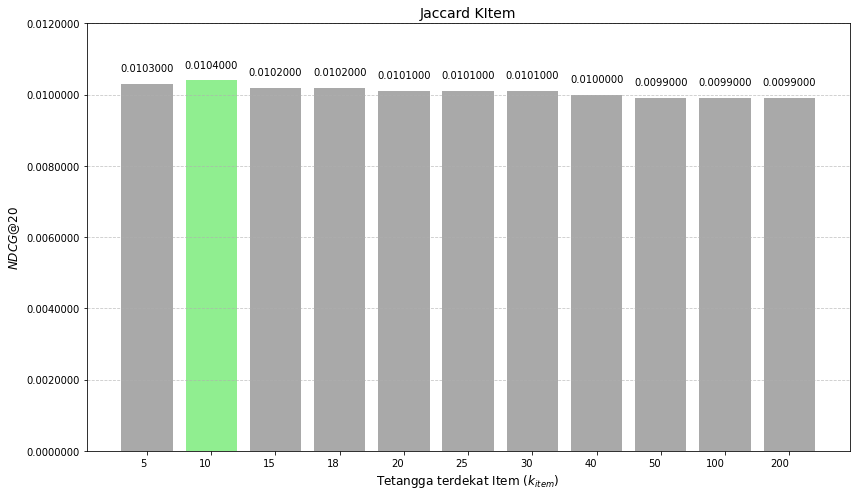

Diagram batang telah dibuat dan disimpan sebagai 'Jaccard KItem.png'


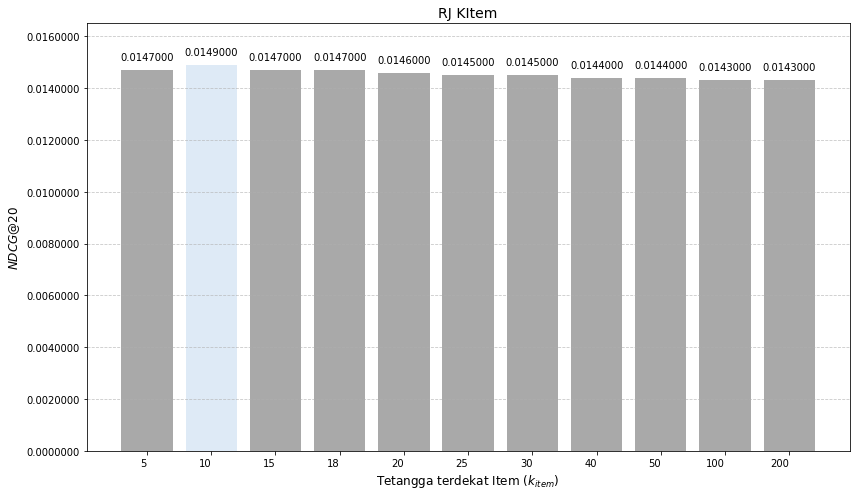

Diagram batang telah dibuat dan disimpan sebagai 'RJ KItem.png'


In [46]:

# Data untuk Jaccard
# x_jaccard = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_jaccard = [0.0100, 0.0087, 0.0082, 0.0080, 0.0079, 0.0078, 0.0076, 0.0075, 0.0073, 0.0069, 0.0066]
# plot_ndcg_bar_chart(x_jaccard, ndcg_jaccard, 'Jaccard KUser', 'Jaccard KUser.png', '#90EE90', 0.011)


xi_Jaccard = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
ndcg_JaccardItem = [0.0103, 0.0104, 0.0102, 0.0102, 0.0101, 0.0101, 0.0101, 0.0100, 0.0099, 0.0099, 0.0099]
plot_ndcg_bar_chart(xi_Jaccard, ndcg_JaccardItem, 'Jaccard KItem', 'Jaccard KItem.png', '#90EE90', 0.012)

# Data untuk RJ
# x_rj = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_rj = [0.0146, 0.0118, 0.0103, 0.0103, 0.0100, 0.0096, 0.0095, 0.0090, 0.0086, 0.0069, 0.0063]
# plot_ndcg_bar_chart(x_rj, ndcg_rj, 'RJ KUser', 'RJ KUser.png', '#DEEAF6', 0.016)

xi_RJ = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
ndcg_RJI = [0.0147, 0.0149, 0.0147, 0.0147, 0.0146, 0.0145, 0.0145, 0.0144, 0.0144, 0.0143, 0.0143]
plot_ndcg_bar_chart(xi_RJ, ndcg_RJI, 'RJ KItem', 'RJ KItem.png', '#DEEAF6', 0.0165)


# hybrid 

# HRJaccard = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# HValueRJac =[0.0085, 0.0089, 0.0094, 0.0102, 0.0112, 0.0122, 0.0133, 0.0149, 0.0165, 0.0179, 0.0191]
# plot_ndcg_bar_chart(HRJaccard, HValueRJac, 'RJaccard Hybrid', 'RJaccard Hybrid.png', '#DEEAF6',  0.021)


# HJaccard = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# HValuekJac = [0.0100, 0.0098, 0.0097, 0.0096, 0.0097, 0.0098, 0.0101, 0.0104, 0.0107, 0.0111, 0.0116]
# plot_ndcg_bar_chart(HJaccard, HValuekJac, 'Jaccard Hybrid', 'Jaccard Hybrid.png', '#90EE90', 0.0125)



# hasil variasi parameter terbaik
# JacTerbaik = [1,2,3,4,5]
# ndcgJacTerbaik = [0.017711,0.013160, 0.008150, 0.006749,0.00466]
# plot_ndcg_bar_chart(JacTerbaik, ndcgJacTerbaik, 'Jaccard KHybrid Terbaik', 'Jaccard KHybrid Terbaik.png', '#90EE90', 0.02)


# RJTerbaik = [1,2,3,4,5]
# ndcgRJTerbaik = [0.026783, 0.017482, 0.013576, 0.010636, 0.007248]
# plot_ndcg_bar_chart(RJTerbaik, ndcgRJTerbaik, 'RJ KHybrid Terbaik', 'RJ KHybrid Terbaik.png', '#DEEAF6', 0.03)


In [50]:
joblib.load("../case/NDCG/RJ/hybridTerbaik/1/5_10_1_ndcg.joblib")

,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.000000,0.168128,0.146068,0.130324,0.118383,0.108936,0.101229,0.094788,0.089306,0.084567,0.080419,0.076751,0.073477,0.070533,0.067868,0.065440,0.063218,0.061173
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## GRAFIK TERBAIK

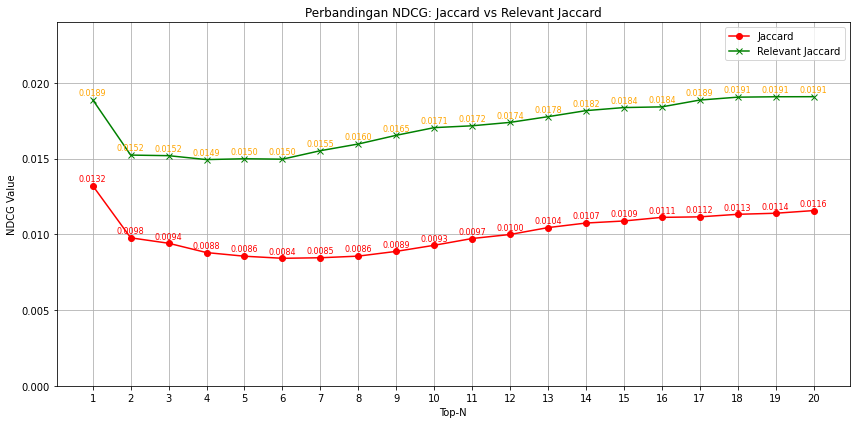

Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid Terbaik.png'


In [60]:
import matplotlib.pyplot as plt

# Data NDCG
jaccard = [
    0.013216, 0.009773, 0.009414, 0.008798, 0.008558, 0.008421, 0.008456, 0.008564,
    0.008878, 0.009280, 0.009727, 0.009993, 0.010448, 0.010749, 0.010885, 0.011124,
    0.011157, 0.011326, 0.011396, 0.011572
]

relevant_jaccard = [0.0188889, 0.015237014, 0.015197826, 0.014940224, 0.014994457, 0.014966919,
 0.015526469, 0.015969519, 0.016543793, 0.017050252, 0.017171821, 0.01739616,
 0.017773384, 0.018172671, 0.018375861, 0.018421325, 0.018870921, 0.019062286,
 0.019089025, 0.019093487]


top_k = list(range(1, 21))

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(top_k, jaccard, marker='o', color='red', label='Jaccard')
plt.plot(top_k, relevant_jaccard, marker='x', color='green', label='Relevant Jaccard')

# Tambahkan nilai di setiap titik
for i in range(20):
    plt.text(top_k[i], jaccard[i] + 0.0003, f"{jaccard[i]:.4f}", color='red', ha='center', fontsize=8)
    plt.text(top_k[i], relevant_jaccard[i] + 0.0003, f"{relevant_jaccard[i]:.4f}", color='orange', ha='center', fontsize=8)

# Konfigurasi grafik
plt.xticks(top_k)
plt.xlabel("Top-N")
plt.ylabel("NDCG Value")
plt.ylim(0, 0.024)  # Atur batas atas sumbu Y
plt.title("Perbandingan NDCG: Jaccard vs Relevant Jaccard")
plt.legend()
plt.grid(True)
plt.tight_layout()
# Menyimpan gambar
plt.savefig(f'../eda_Img/Bobot Hybrid Terbaik.png')

# Menampilkan diagram
plt.show()

print("Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid Terbaik.png'")


## GRAFIK PERSENTASE KENAIKAN

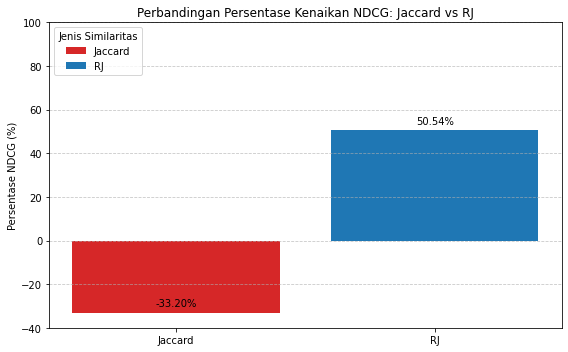

In [ ]:
import matplotlib.pyplot as plt

# Ukuran grafik
fig, ax = plt.subplots(figsize=(8, 5))

# Data
similaritas = ['Jaccard', 'RJ']
counts = [-33.20, 50.54]  # Dalam persen
bar_colors = ['tab:red', 'tab:blue']

# Plot batang satu per satu dengan warna sesuai
for i in range(len(similaritas)):
    ax.bar(similaritas[i], counts[i], label=similaritas[i], color=bar_colors[i])

# Label dan judul
ax.set_ylabel('Persentase NDCG (%)')
ax.set_title('Perbandingan Persentase Kenaikan NDCG: Jaccard vs RJ')

# Atur rentang Y axis
ax.set_ylim(-40, 100)

# Tampilkan nilai di atas batang
for i in range(len(similaritas)):
    ax.text(similaritas[i], counts[i] + 2, f'{counts[i]:.2f}%', ha='center', va='bottom', fontsize=10)

# Tambahkan grid horizontal bergaya kotak-kotak
# plt.grid(True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Legenda
ax.legend(title='Jenis Similaritas', loc='upper left')

plt.tight_layout()
# plt.savefig(f'../eda_Img/Persentase Kenaikan NDCG.png')

# Menampilkan diagram
plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'Persentase Kenaikan NDCG.png'")
   

## GRAFIK TIAP FOLD TERBAIK 

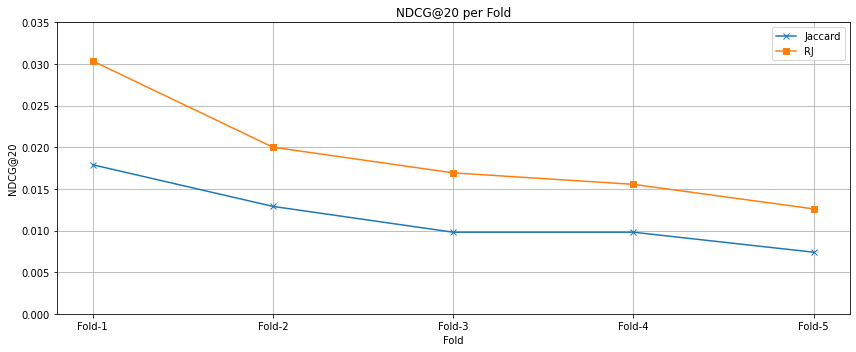

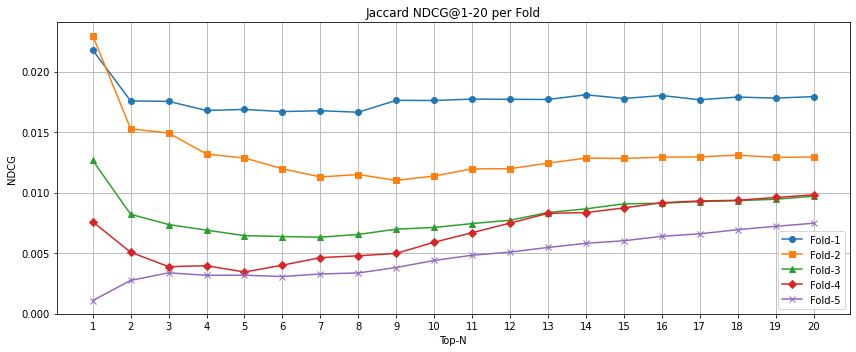

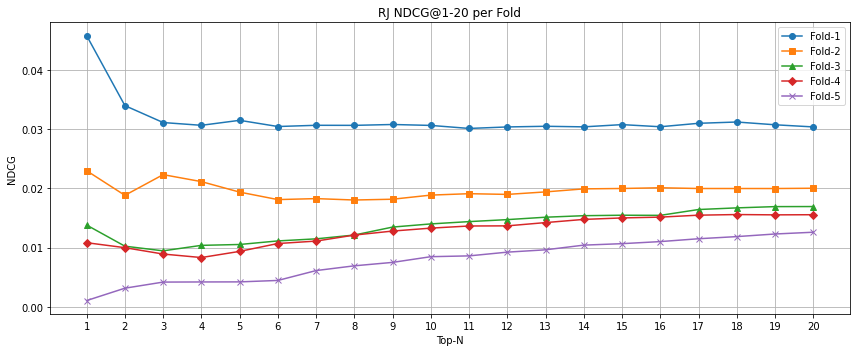

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Data NDCG@20 per fold
ndcg20_jaccard = [0.0179, 0.0129, 0.0098, 0.0098, 0.0074]
ndcg20_rj = [0.03036, 0.02001, 0.01693, 0.01555, 0.01260]

# Data NDCG@1-20 (Top-N) per fold
topn = list(range(1, 21))
jaccard_topn = np.array([
    [0.021786, 0.022971, 0.012658, 0.007584, 0.001079],
    [0.017572, 0.015269, 0.008207, 0.005069, 0.002748],
    [0.017539, 0.014921, 0.007361, 0.003880, 0.003369],
    [0.016788, 0.013184, 0.006897, 0.003956, 0.003165],
    [0.016872, 0.012861, 0.006445, 0.003437, 0.003174],
    [0.016697, 0.011970, 0.006371, 0.004001, 0.003065],
    [0.016764, 0.011294, 0.006314, 0.004627, 0.003278],
    [0.016643, 0.011493, 0.006545, 0.004776, 0.003361],
    [0.017624, 0.011005, 0.006978, 0.004975, 0.003810],
    [0.017612, 0.011376, 0.007119, 0.005899, 0.004391],
    [0.017727, 0.011958, 0.007440, 0.006686, 0.004824],
    [0.017711, 0.011974, 0.007717, 0.007481, 0.005083],
    [0.017697, 0.012438, 0.008354, 0.008283, 0.005468],
    [0.018083, 0.012849, 0.008655, 0.008350, 0.005809],
    [0.017776, 0.012823, 0.009071, 0.008733, 0.006022],
    [0.018024, 0.012923, 0.009123, 0.009165, 0.006386],
    [0.017672, 0.012955, 0.009257, 0.009310, 0.006593],
    [0.017897, 0.013095, 0.009337, 0.009364, 0.006936],
    [0.017807, 0.012910, 0.009450, 0.009598, 0.007213],
    [0.017936, 0.012938, 0.009702, 0.009813, 0.007468]
]).T

rj_topn = np.array([
    [0.045752, 0.022971, 0.013809, 0.010834, 0.001079],
    [0.033952, 0.018824, 0.010248, 0.009996, 0.003165],
    [0.031098, 0.022312, 0.009463, 0.008922, 0.004194],
    [0.030631, 0.021136, 0.010387, 0.008332, 0.004215],
    [0.031472, 0.019367, 0.010534, 0.009371, 0.004228],
    [0.030428, 0.018105, 0.011135, 0.010697, 0.004470],
    [0.030634, 0.018270, 0.011486, 0.011107, 0.006136],
    [0.030623, 0.018034, 0.012130, 0.012122, 0.006937],
    [0.030769, 0.018167, 0.013470, 0.012798, 0.007515],
    [0.030613, 0.018862, 0.014004, 0.013293, 0.008478],
    [0.030103, 0.019100, 0.014392, 0.013652, 0.008612],
    [0.030355, 0.018980, 0.014728, 0.013675, 0.009243],
    [0.030469, 0.019401, 0.015134, 0.014227, 0.009636],
    [0.030371, 0.019913, 0.015389, 0.014764, 0.010426],
    [0.030748, 0.019978, 0.015469, 0.015012, 0.010672],
    [0.030389, 0.020098, 0.015448, 0.015149, 0.011022],
    [0.030970, 0.019975, 0.016430, 0.015477, 0.011503],
    [0.031187, 0.019973, 0.016707, 0.015582, 0.011863],
    [0.030720, 0.019971, 0.016921, 0.015531, 0.012303],
    [0.030360, 0.020018, 0.016932, 0.015554, 0.012602]
]).T

markers = ['o', 's', '^', 'D', 'x']  # Tambahkan lebih banyak jika ada lebih banyak fold

# ---------------------
# Gambar 1: NDCG@20 per Fold
# ---------------------
plt.figure(figsize=(12, 5))
plt.plot(ndcg20_jaccard, label='Jaccard', marker=markers[i])
plt.plot(ndcg20_rj, label='RJ', marker='s')
plt.title('NDCG@20 per Fold')
plt.xlabel('Fold')
plt.ylabel('NDCG@20')
plt.xticks(np.arange(5), [f'Fold-{i+1}' for i in range(5)])
plt.ylim(0, 0.035)  # Atur batas atas sumbu Y
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'../eda_Img/NDGC@20.png')
plt.show()

# ---------------------
# Gambar 2: Jaccard NDCG@1-20 per Fold
# ---------------------
plt.figure(figsize=(12, 5))
for i in range(5):
    plt.plot(topn, jaccard_topn[i], label=f'Fold-{i+1}',marker=markers[i])
plt.title('Jaccard NDCG@1-20 per Fold')
plt.xlabel('Top-N')
plt.xticks(topn)  # Menampilkan semua nilai Top-N dari 1 sampai 20
plt.ylabel('NDCG')
# Tambahkan nilai di setiap titik
# for i in range(20):
#     plt.text(topn[i], jaccard_topn[0][i] + 0.0003, f"{jaccard_topn[0][i]:.4f}", color='red', ha='center', fontsize=8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'../eda_Img/Jaccard NDCG@1-20-Fold.png')
plt.show()

# ---------------------
# Gambar 3: RJ NDCG@1-20 per Fold
# ---------------------
plt.figure(figsize=(12, 5))
for i in range(5):
    plt.plot(topn, rj_topn[i], label=f'Fold-{i+1}',marker=markers[i])
plt.title('RJ NDCG@1-20 per Fold')
plt.xlabel('Top-N')
plt.xticks(topn)  # Menampilkan semua nilai Top-N dari 1 sampai 20
plt.ylabel('NDCG')
# # Tambahkan nilai di setiap titik
# for i in range(20):
#     plt.text(topn[i], rj_topn[0][i] + 0.0003, f"{rj_topn[0][i]:.4f}", color='blue', ha='center', fontsize=8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'../eda_Img/RJ NDCG@1-20-Fold.png')
plt.show()
